## Exercise

**1 - Create the environment Gridworld**

In [1]:
UP, DOWN, LEFT, RIGHT = range(4)

class Space:
    def __init__(self, value):
        self.n = value
        
class GridWorld:
    
    # 0:UP, 1:DOWN, 2:LEFT 3:RIGHT
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = Space(12)
        self.state = 8
        self.columns = 4
        self.rows = 3
        self.done = False
        self.reward = 0
        return self.state
    
    def step(self, action):
        if self.done: raise ValueError('Episode has terminated')
        if action not in [UP, DOWN, LEFT, RIGHT]: raise ValueError('Invalid action')
        
        if action == UP: action = np.random.choice([UP, LEFT, RIGHT], p=[0.8, 0.1, 0.1])
        if action == DOWN: action = np.random.choice([DOWN, LEFT, RIGHT], p=[0.8, 0.1, 0.1])
        if action == LEFT: action = np.random.choice([LEFT, UP, DOWN], p=[0.8, 0.1, 0.1])
        if action == RIGHT: action = np.random.choice([RIGHT, UP, DOWN], p=[0.8, 0.1, 0.1])
        
        row    = self.state // self.columns
        column = self.state % self.columns
        if action == LEFT: column = max(column - 1, 0)
        if action == DOWN: row = min(row + 1, self.rows - 1)
        if action == RIGHT: column = min(column + 1, self.columns - 1)
        if action == UP: row = max(row - 1, 0)
        self.state = row * self.columns + column
        
        self.reward = 0
        if self.state == 3: self.done = True; self.reward = 1
        elif self.state == 5: self.done = True; self.reward = -1   
        
        return self.state, self.reward, self.done, 0


In [2]:
env = GridWorld()

**2 - Write the optimal policy for this environment**

In [3]:
pi = lambda s: {
    0:RIGHT, 1:RIGHT, 2:RIGHT, 3:LEFT,
    4:UP,    5:LEFT,  6:UP,    7:LEFT,
    8:UP,    9:LEFT, 10:LEFT, 11:LEFT
}[s]

In [4]:
def print_policy(pi, env, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for state in range(env.observation_space.n):
        action = pi(state)
        action_icon = ''
        if action == UP: action_icon = '^'
        if action == DOWN: action_icon = '_'
        if action == LEFT: action_icon = '<-'
        if action == RIGHT: action_icon = '->'
        print('state:', state, '->', 'action:', action_icon)

In [5]:
print_policy(pi, env)

Policy:
state: 0 -> action: ->
state: 1 -> action: ->
state: 2 -> action: ->
state: 3 -> action: <-
state: 4 -> action: ^
state: 5 -> action: <-
state: 6 -> action: ^
state: 7 -> action: <-
state: 8 -> action: ^
state: 9 -> action: <-
state: 10 -> action: <-
state: 11 -> action: <-


**3 - Now, evaluate this policy using TD($\lambda$)**

In [6]:
import numpy as np

def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [7]:
def td_lambda(pi, env, gamma=1.0,
              init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
              lambda_=0.2, n_episodes=500):
    nS = env.observation_space.n
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    E = np.zeros(nS, dtype=np.float64)
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    for e in range(n_episodes):
        E.fill(0)
        state, done = env.reset(), False
        while not done:
            action = pi(state)
            next_state, reward, done, _ = env.step(action)
            td_target = reward + gamma * V[next_state] * (not done)
            td_error = td_target - V[state]
            E[state] = E[state] + 1
            V = V + alphas[e] * td_error * E
            E = gamma * lambda_ * E
            state = next_state
        V_track[e] = V
    return V, V_track

In [12]:
V_td_lambda, V_td_lambda_track = td_lambda(pi, env, lambda_=0.3, n_episodes=1500)

In [13]:
print(V_td_lambda)

[0.70359538 0.74695723 0.97478163 0.         0.51576423 0.
 0.74651685 0.34984363 0.50470875 0.41319305 0.02771197 0.00406044]


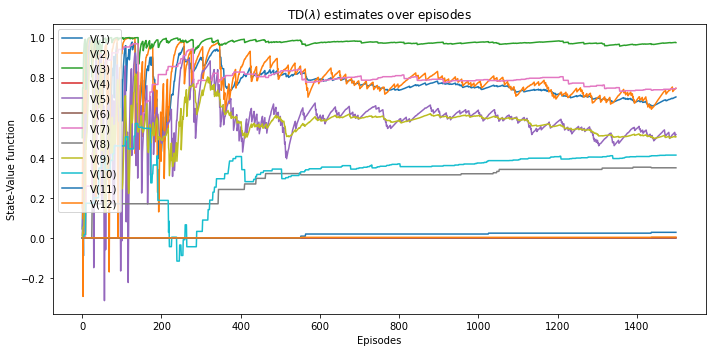

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
legends = ['V(1)','V(2)','V(3)','V(4)','V(5)','V(6)','V(7)','V(8)','V(9)','V(10)','V(11)','V(12)']
plt.plot(V_td_lambda_track)
plt.title('TD($\lambda$) estimates over episodes')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()